<a href="https://colab.research.google.com/github/Pakeith0805/SparkPlus_Assignment/blob/staging/Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

SparkPlusの採用課題です。

- ラベル「0」： airplane（飛行機）
- ラベル「1」： automobile（自動車）
- ラベル「2」： bird（鳥）
- ラベル「3」： cat（猫）
- ラベル「4」： deer（鹿）
- ラベル「5」： dog（犬）
- ラベル「6」： frog（カエル）
- ラベル「7」： horse（馬）
- ラベル「8」： ship（船）
- ラベル「9」： truck（トラック）

# 前処理

In [10]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts

In [11]:
# ちゃんとgpuになってるか確認。
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [12]:
# 前処理をまとめる
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(), # ランダムに左右対称にする
    transforms.ColorJitter(), # ランダムに色を変える。
    transforms.ToTensor(), # 画像をTensorクラスに変えて、チャネルファーストに変えてくれる。
    transforms.Normalize((0.5,), (0.5,)) # 平均、標準偏差を0.5に
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# 訓練用データセットと検証用データセットを作成
train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=train_transform)
vilidation_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=val_transform)

In [13]:
# データを作る。
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_dataloader = DataLoader(vilidation_dataset, batch_size=32, shuffle=False)

In [14]:
# CNNを実装。
class CNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, padding=2), # RGBなのでin_channelsは3、畳み込むたびに2ずつ画像が小さくなるため、2補う。
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2), # 32×32の画像が16×16になる。
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1), # RGBなのでin_channelsは3、畳み込むたびに2ずつ画像が小さくなるため、2補う。
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2), # 16×16の画像が8×8になる。
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1), # RGBなのでin_channelsは3、畳み込むたびに2ずつ画像が小さくなるため、2補う。
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2), # 8×8の画像が4×4になる。
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1), # RGBなのでin_channelsは3、畳み込むたびに2ずつ画像が小さくなるため、2補う。
            nn.ReLU(inplace=True),
        )
        self.classifier = nn.Linear(in_features=4 * 4 * 128, out_features=num_classes) # in_featuresには1次元ベクトルにして渡す。4×4が128個ある。out_featuresは何個に分類するか。
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1) # x.size(0)はバッチ数を表す。(32, 4×4×128)という形になる。
        x = self.classifier(x)
        return x

In [15]:
# modelを作成
model = CNN(10) # 10はクラス数
model.to(device)

CNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
  )
  (classifier): Linear(in_features=2048, out_features=10, bias=True)
)

In [16]:
# 損失関数とoptimizerを設定
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4) # weight_decayで重みづけが大きくなりすぎないようにしている。
# CosineAnnealingWarmRestartsの設定
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2, eta_min=0.)

In [17]:
# ラベルをone-hotに変換する関数
def one_hot_encode(labels, num_classes):
    return torch.eye(num_classes, device=labels.device)[labels]

# 平滑化の損失関数
def label_smoothed_nll_loss(lprobs, target, eps):
    nll_loss = -lprobs.gather(dim=-1, index=target.unsqueeze(-1))
    nll_loss = nll_loss.squeeze(-1)  # ラベルの次元を削除
    nll_loss = nll_loss.mean()

    smooth_loss = -lprobs.mean(dim=-1)
    smooth_loss = smooth_loss.mean()

    loss = (1.0 - eps) * nll_loss + eps * smooth_loss
    return loss

In [18]:
# 学習のループ
num_epochs = 15
losses = []
accs = []
val_losses = []
val_accs = []
for epoch in range(num_epochs):
    running_loss = 0.0
    running_acc = 0.0
    y_true = []  # 正解ラベルを保存
    y_pred = []  # 予測ラベルを保存
    for imgs, labels, in train_dataloader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        # ラベルをone-hotエンコード
        one_hot_labels = one_hot_encode(labels, num_classes=10)

        optimizer.zero_grad() # 勾配の初期化
        output = model(imgs)

        # ソフトマックス後のlog確率を計算
        lprobs = torch.log_softmax(output, dim=-1)

        # 平滑化した損失を計算
        loss = label_smoothed_nll_loss(lprobs, labels, eps=0.1)

        loss.backward()
        running_loss += loss.item()
        pred = torch.argmax(output, dim=1)
        prob_pred = torch.softmax(output, dim=1)
        running_acc += torch.mean(pred.eq(labels).float())
        optimizer.step()
        y_true.extend(labels.cpu().numpy())  # GPU->CPU
        y_pred.extend(pred.cpu().numpy())  # GPU->CPU
    running_loss /= len(train_dataloader)
    running_acc /= len(train_dataloader)
    losses.append(running_loss)
    #accs.append(running_acc)
    accs.append(running_acc.cpu())
    scheduler.step()
#
# validationのループ
#
    val_running_loss = 0.0
    val_running_acc = 0.0
    y_val_true = []  # 正解ラベルを保存
    y_val_pred = []  # 予測ラベルを保存
    for val_imgs, val_labels in validation_dataloader:
        val_imgs = val_imgs.to(device)
        val_labels = val_labels.to(device)
        val_output = model(val_imgs)

        val_lprobs = torch.log_softmax(val_output, dim=-1)
        val_loss = label_smoothed_nll_loss(val_lprobs, val_labels, eps=0.1)

        val_running_loss += val_loss.item()
        val_pred = torch.argmax(val_output, dim=1)
        val_running_acc += torch.mean(val_pred.eq(val_labels).float())
        # ラベルを保存
        y_val_true.extend(val_labels.cpu().numpy())  # GPU->CPU
        y_val_pred.extend(val_pred.cpu().numpy())  # GPU->CPU

    val_running_loss /= len(validation_dataloader)
    val_running_acc /= len(validation_dataloader)
    val_losses.append(val_running_loss)
    #val_accs.append(val_running_acc)
    val_accs.append(val_running_acc.cpu())
    print("epoch: {}, loss: {}, acc: {}, \
     val loss: {}, val acc: {}".format(epoch, running_loss, running_acc, val_running_loss, val_running_acc))

epoch: 0, loss: 1.594924316448961, acc: 0.49842050671577454,      val loss: 1.3639146676078773, val acc: 0.6153154969215393
epoch: 1, loss: 1.239043148488321, acc: 0.6804622411727905,      val loss: 1.1680483446715357, val acc: 0.7162539958953857
epoch: 2, loss: 1.0960811120687353, acc: 0.7519993782043457,      val loss: 1.1011697646147145, val acc: 0.7491014003753662
epoch: 3, loss: 1.0006850541820147, acc: 0.7993242144584656,      val loss: 1.0457712739420395, val acc: 0.776457667350769
epoch: 4, loss: 0.9325324621096835, acc: 0.8330334424972534,      val loss: 1.0044660155003824, val acc: 0.8002196550369263
epoch: 5, loss: 1.050558610253813, acc: 0.774472177028656,      val loss: 1.0740190582534375, val acc: 0.763079047203064
epoch: 6, loss: 1.012609765152861, acc: 0.7928262948989868,      val loss: 1.087899686048587, val acc: 0.758286714553833
epoch: 7, loss: 0.9814376571738255, acc: 0.80782151222229,      val loss: 1.0459010641034039, val acc: 0.7744608521461487
epoch: 8, loss: 0.

In [19]:
labels

tensor([0, 1, 6, 1, 2, 6, 3, 6, 7, 1, 9, 8, 4, 2, 8, 7], device='cuda:0')

In [20]:
one_zero_labels = torch.where(labels == 0, 1, 0)
print(one_zero_labels)

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


In [21]:
prob = prob_pred[:, 0]

In [22]:
prob
# probはラベル0の確率。これ使ってroc曲線かける

tensor([0.8131, 0.0120, 0.0038, 0.0070, 0.0013, 0.0071, 0.0043, 0.0044, 0.0075,
        0.0038, 0.0011, 0.0009, 0.0185, 0.0031, 0.0136, 0.0176],
       device='cuda:0', grad_fn=<SelectBackward0>)

In [23]:
roc = roc_curve(one_zero_labels.cpu().detach().numpy(), prob.cpu().detach().numpy())

In [24]:
fpr, tpr, thresholds = roc

print(fpr)
# [0.   0.   0.25 0.25 0.5  0.5  1.  ]

print(tpr)
# [0.   0.25 0.25 0.5  0.5  1.   1.  ]

print(thresholds)
# [1.9 0.9 0.8 0.7 0.6 0.4 0.2]

[0. 0. 1.]
[0. 1. 1.]
[       inf 0.81308645 0.0008947 ]


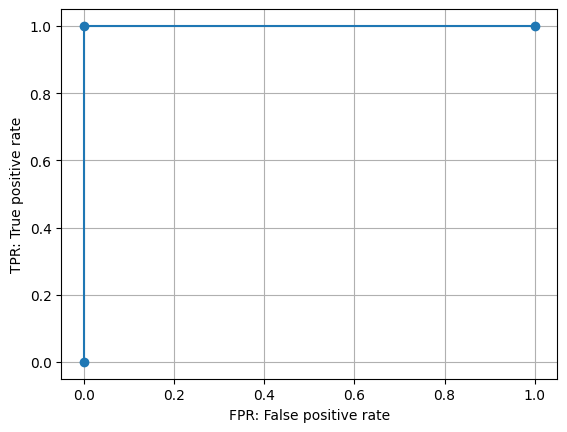

In [25]:
plt.plot(fpr, tpr, marker='o')
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()

# 評価項目

In [26]:
# 正解率
print(accs[-1].cpu())
print(val_accs[-1].cpu())
# 混同行列
cm=confusion_matrix(y_true, y_pred)
val_cm=confusion_matrix(y_val_true, y_val_pred)
print(cm)
print(val_cm)
# 再現率：実際に真だったもののうち、モデルが真と判断した割合。
# 見逃しをなくしたいときに使われる。
# 別名真陽性率。
recall_per_class = cm.diagonal() / cm.sum(axis=1)
val_recall_per_class = val_cm.diagonal() / val_cm.sum(axis=1)
print(recall_per_class)
print(val_recall_per_class)
# 適合率：モデルが真と判断し、実際に真だった割合。猫と判断し、実際に猫だった割合。
# 誤検出をなくしたいときに使われる。
precision_per_class = cm.diagonal() / cm.sum(axis=0)
val_precision_per_class = val_cm.diagonal() / val_cm.sum(axis=0)
print(precision_per_class)
print(val_precision_per_class)
# F1スコア：適合率と再現率の調和平均。
f1_per_class = 2 * (precision_per_class * recall_per_class) / (precision_per_class + recall_per_class)
val_f1_per_class = 2 * (val_precision_per_class * val_recall_per_class) / (val_precision_per_class + val_recall_per_class)
print(f1_per_class)
print(val_f1_per_class)
# 偽陽性率：実際に偽だったったもののうち、モデルが間違えて真と判断した割合。

tensor(0.9328)
tensor(0.8358)
[[4764   16   50   37   19   10   15    7   54   28]
 [  16 4882    5   10    3    5    6    3   15   55]
 [  99    3 4519   87   95   68   80   28   10   11]
 [  29    1   89 4299   94  297  102   61   19    9]
 [  27    0   76   83 4635   52   47   66   10    4]
 [  12    4   69  320   90 4358   41   88   10    8]
 [  14    4   63   76   40   32 4753    4   10    4]
 [  15    2   35   72   60   51    6 4745    4   10]
 [  50   24   15   13    8    5    6    2 4849   28]
 [  35   56   14   20    3    3   10    3   20 4836]]
[[877   7  29  13   7   5   3   5  29  25]
 [ 15 914   3   4   1   4   3   2   9  45]
 [ 46   2 758  40  51  44  32  17   7   3]
 [ 19   2  48 682  44 123  40  25   8   9]
 [ 15   2  47  40 803  19  29  38   6   1]
 [  7   1  22 113  31 776  11  34   3   2]
 [  6   2  28  35  21  15 885   3   3   2]
 [ 12   1  17  25  35  39   4 851   2  14]
 [ 36  12   7   9   1   4   3   3 906  19]
 [ 19  37   6   7   2   1   1   4  19 904]]
[0.9528 

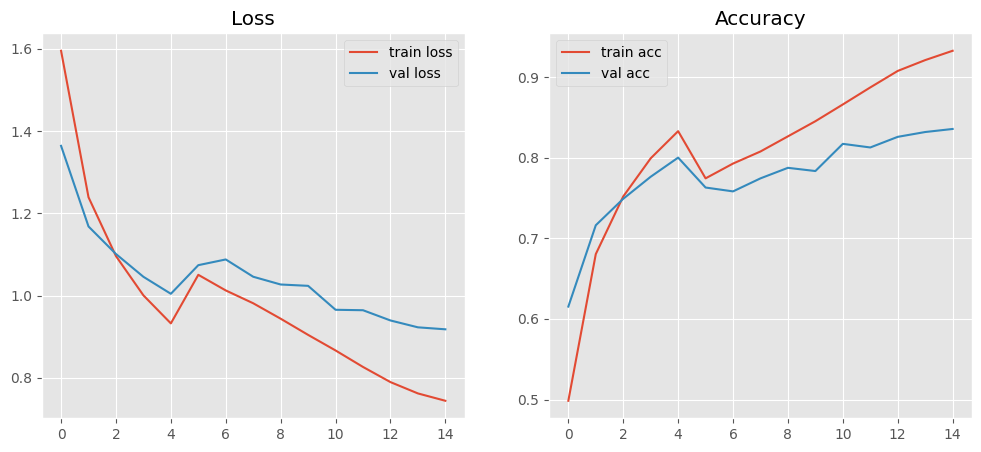

In [27]:
plt.style.use("ggplot")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1行2列のサブプロット

# 左のグラフ(損失)
axes[0].plot(losses, label="train loss")
axes[0].plot(val_losses, label="val loss")
axes[0].legend()
axes[0].set_title("Loss")

# 右のグラフ(精度)
axes[1].plot(accs, label="train acc")
axes[1].plot(val_accs, label="val acc")
axes[1].legend()
axes[1].set_title("Accuracy")

plt.show()

In [28]:
print(accs)
print(val_accs)

[tensor(0.4984), tensor(0.6805), tensor(0.7520), tensor(0.7993), tensor(0.8330), tensor(0.7745), tensor(0.7928), tensor(0.8078), tensor(0.8266), tensor(0.8454), tensor(0.8662), tensor(0.8873), tensor(0.9078), tensor(0.9212), tensor(0.9328)]
[tensor(0.6153), tensor(0.7163), tensor(0.7491), tensor(0.7765), tensor(0.8002), tensor(0.7631), tensor(0.7583), tensor(0.7745), tensor(0.7875), tensor(0.7835), tensor(0.8173), tensor(0.8128), tensor(0.8260), tensor(0.8320), tensor(0.8358)]


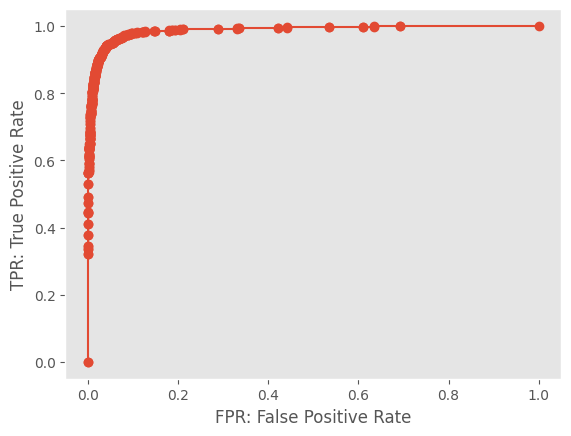

In [29]:
# y_val_true はラベル（0 or 1）を含むリスト
y_val_true = torch.tensor(y_val_true)

# val_output に softmax を適用
val_output_tensor = torch.cat([model(val_imgs.to(device)) for val_imgs, _ in validation_dataloader])
val_prob_pred = torch.softmax(val_output_tensor, dim=1)

# クラス0の確率値を取得
prob = val_prob_pred[:, 0].cpu().detach().numpy()

# 0/1 ラベルの取得
one_zero_labels = torch.where(y_val_true == 0, 1, 0).cpu().detach().numpy()

# ROC曲線の計算
fpr, tpr, thresholds = roc_curve(one_zero_labels, prob)

# グラフ描画
plt.plot(fpr, tpr, marker='o')
plt.xlabel('FPR: False Positive Rate')
plt.ylabel('TPR: True Positive Rate')
plt.grid()
plt.show()


ROC AUC Score: 0.9870
ROC AUC Score: 0.9951
ROC AUC Score: 0.9724
ROC AUC Score: 0.9561
ROC AUC Score: 0.9817
ROC AUC Score: 0.9723
ROC AUC Score: 0.9905
ROC AUC Score: 0.9897
ROC AUC Score: 0.9944
ROC AUC Score: 0.9935


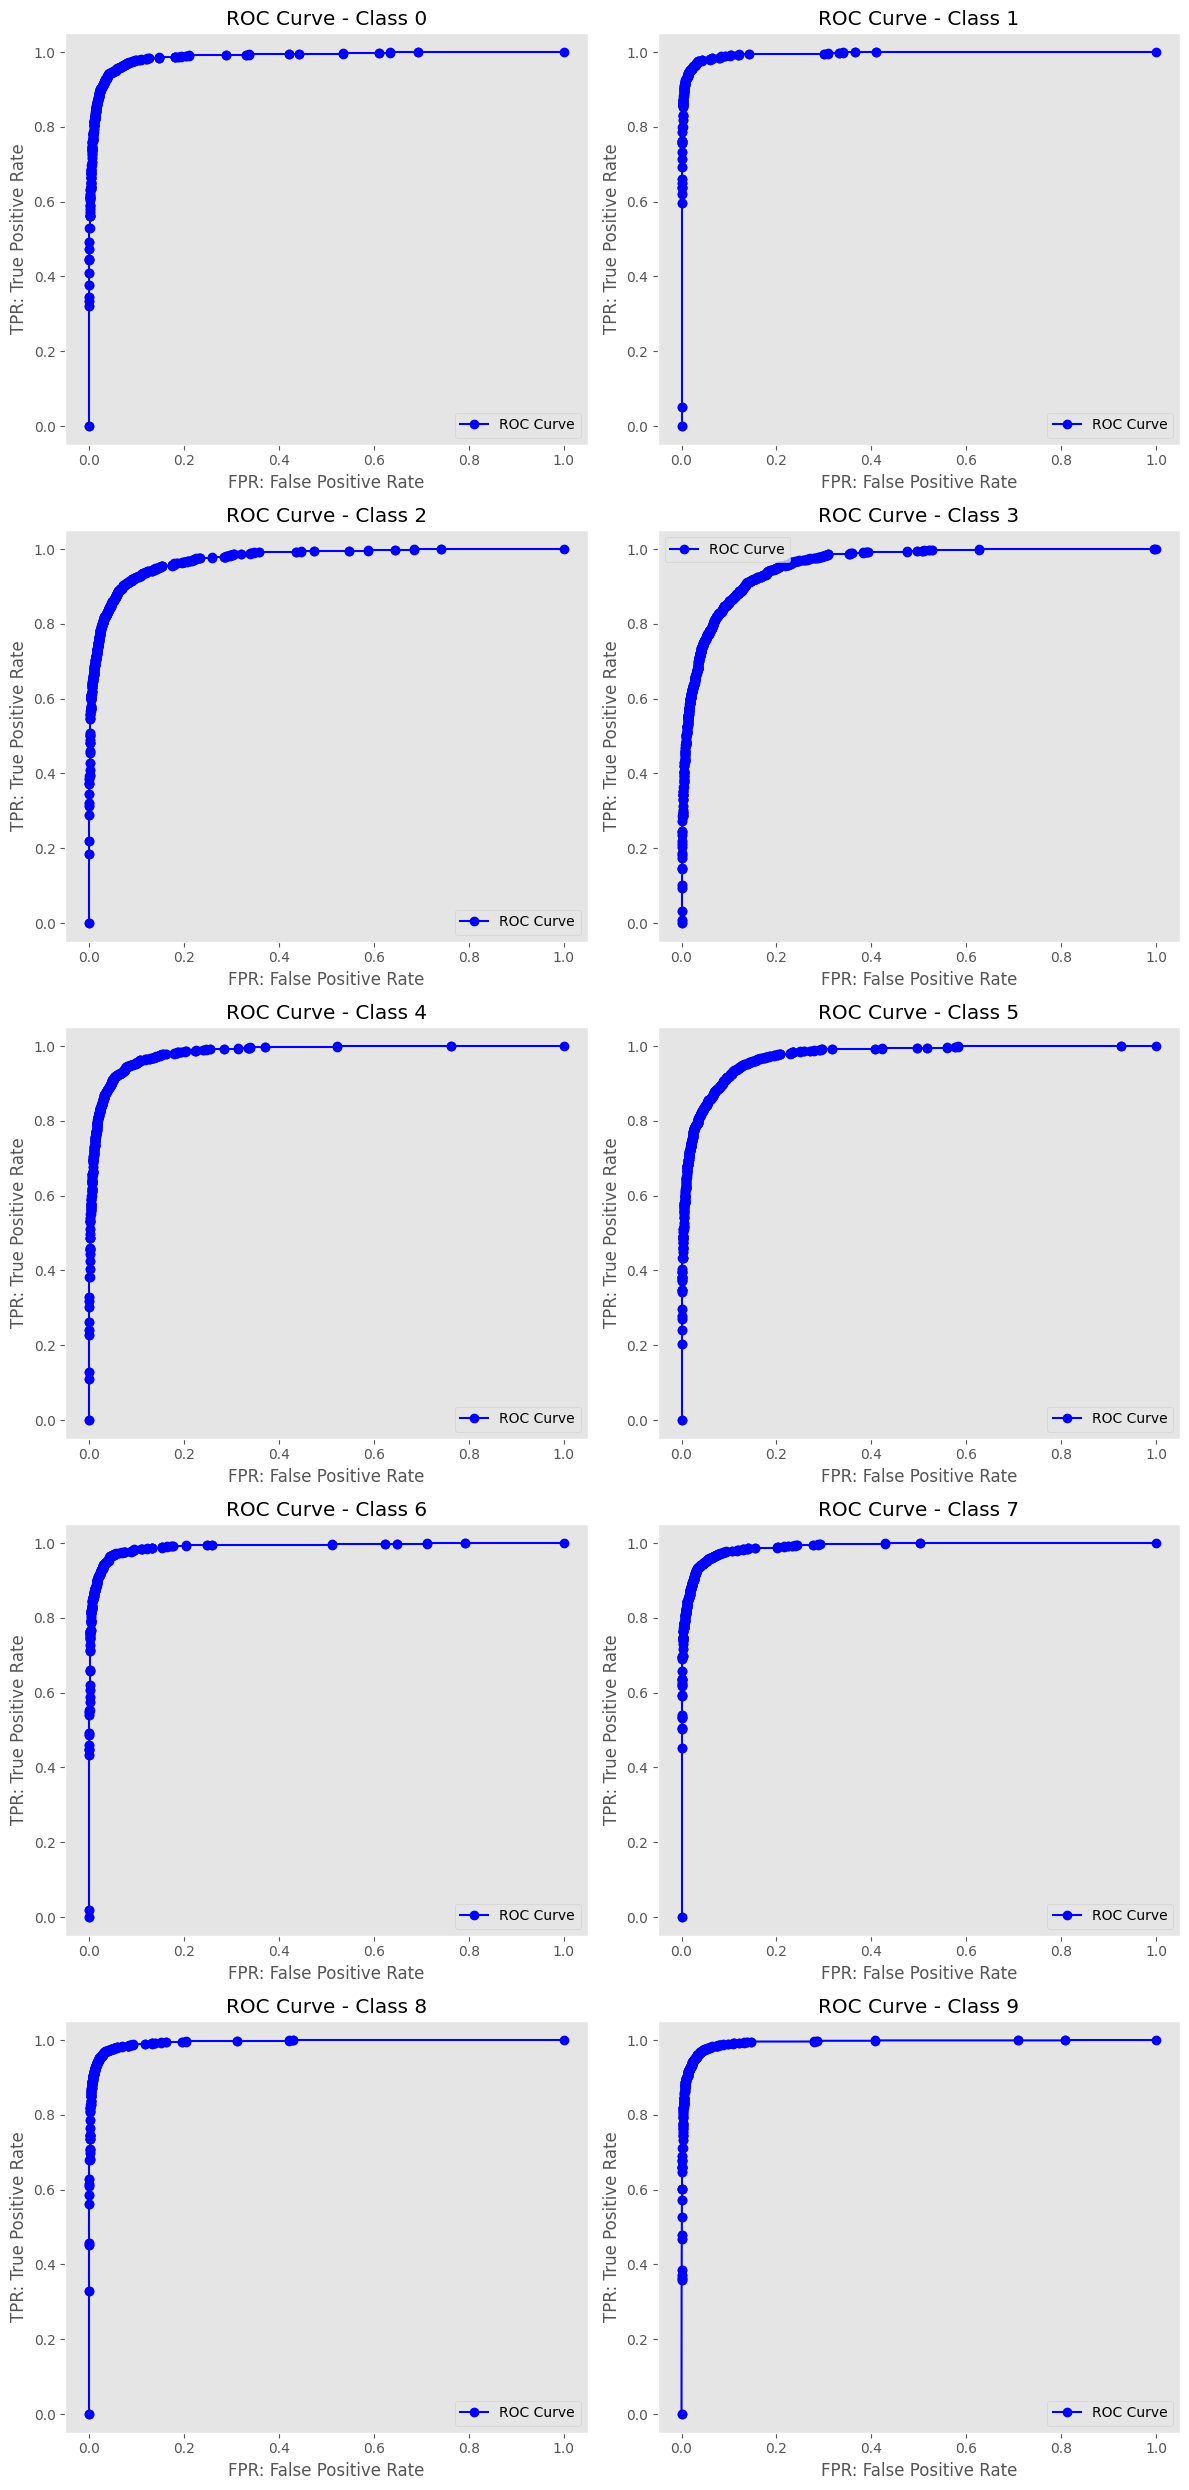

In [30]:
def make_roc_curve():
    fig, axes = plt.subplots(5, 2, figsize=(12, 25))  # 5行2列のサブプロット

    for n in range(10):

        # クラス0の確率値を取得
        prob = val_prob_pred[:, n].cpu().detach().numpy()

        # 0/1 ラベルの取得
        one_zero_labels = torch.where(y_val_true == n, 1, 0).cpu().detach().numpy()

        # ROC曲線の計算
        fpr, tpr, thresholds = roc_curve(one_zero_labels, prob)

        # auc算出
        auc_score = roc_auc_score(one_zero_labels, prob)
        print(f"ROC AUC Score: {auc_score:.4f}")

        # 行インデックスと列インデックスの計算
        row_idx = n // 2  # 行インデックス
        col_idx = n % 2   # 列インデックス

        # グラフ描画
        axes[row_idx, col_idx].plot(fpr, tpr, marker='o', color='b', label="ROC Curve")
        axes[row_idx, col_idx].set_xlabel('FPR: False Positive Rate')
        axes[row_idx, col_idx].set_ylabel('TPR: True Positive Rate')
        axes[row_idx, col_idx].set_title(f'ROC Curve - Class {n}')
        axes[row_idx, col_idx].legend()
        axes[row_idx, col_idx].grid()
    plt.tight_layout()
    plt.show()

make_roc_curve()